In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
sys.path.insert(0,"/home/panhailin/software/source/git_hub/spateo-release/")
import spateo as st
import dynamo as dyn
import cv2
import anndata as ad
import pandas as pd
from scipy import stats
import pickle

2023-04-23 11:05:31.854759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/panhailin/miniconda3/envs/spateo/lib/python3.8/site-packages/spaghetti-1.6.5-py3.8.egg/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.



|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


## Old

In [2]:
olf = st.io.read_bgi_agg('/DATA/User/zhangzhewei/starro/all_crop0.gem.gz')

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


In [15]:
olf.X = olf.X.todense()
olf.X = np.log2(olf.X + 1)

In [22]:
olf.X = olf.X * (-1)

|-----> <select> X layer in AnnData Object


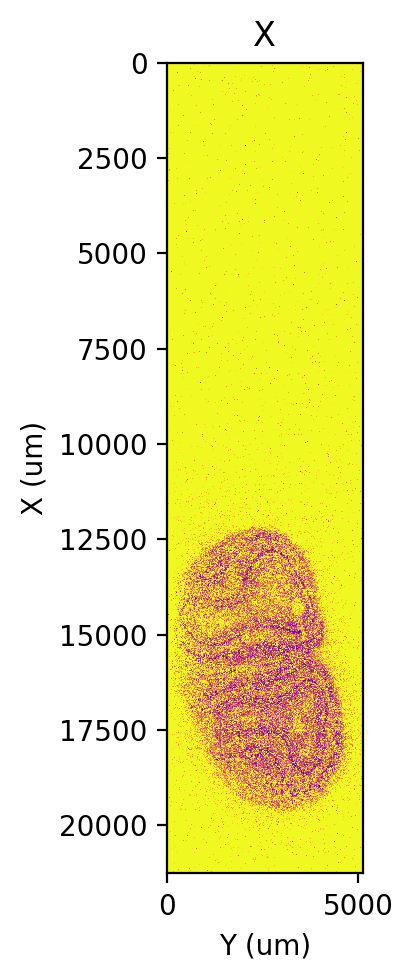

In [26]:
st.pl.imshow(olf, 'X', vmin=-np.log2(513), vmax=-np.log2(5), cmap="plasma")

In [3]:
adata = ad.read("/DATA/User/zhangzhewei/starro/slcFOV1896.h5ad")

In [121]:
adata = olf[29000:30000, 2000:3000]
adata.uns['spatial']['scale'] = 0.325

In [152]:
adata.uns['spatial']

{'binsize': 1, 'scale': 0.325, 'scale_unit': 'um'}

|-----> <select> nuclear layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> <select> X layer in AnnData Object


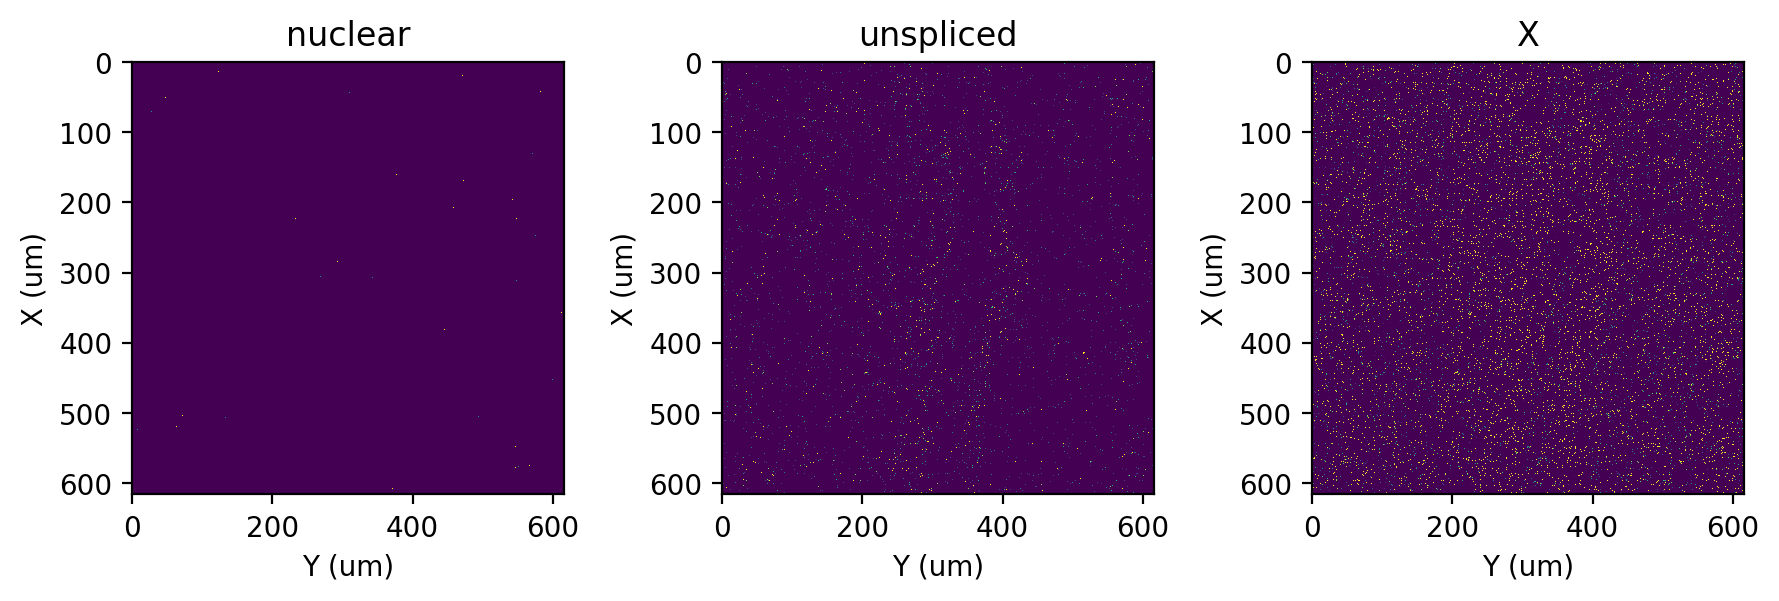

In [153]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
st.pl.imshow(adata, 'nuclear', ax=axes[0], vmax=2, save_show_or_return='return')
st.pl.imshow(adata, 'unspliced', ax=axes[1], vmax=5, save_show_or_return='return')
st.pl.imshow(adata, 'X', ax=axes[2], vmax=16)

|-----> <select> nuclear layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> nuclear_bins to layers in AnnData Object.
|-----> <select> nuclear_bins layer in AnnData Object


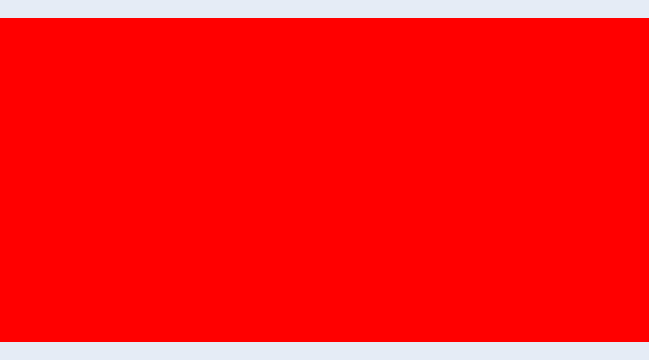

In [154]:
st.cs.segment_densities(adata, 'nuclear', 50, k=3, dk=3, distance_threshold=3, background=False)
st.pl.contours(adata, 'nuclear_bins', scale=0.15)

|-----> <select> nuclear layer in AnnData Object
|-----> <select> nuclear_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.
|-----? Bin 1 estimated variance of foreground (4.71e+00) is less than the mean (4.74e+00). Initial variance will be arbitrarily set to 1.1x of the mean. This is usually due to extreme sparsity. Please consider increasing `k` or using the zero-inflated distribution.


Loss 1.6496e-02: 100%|██████████| 500/500 [00:15<00:00, 32.74it/s]


|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.46868704639238173.
threshold: 0.46868704639238173
|-----> <insert> nuclear_mask to layers in AnnData Object.
|-----> <select> nuclear_mask layer in AnnData Object


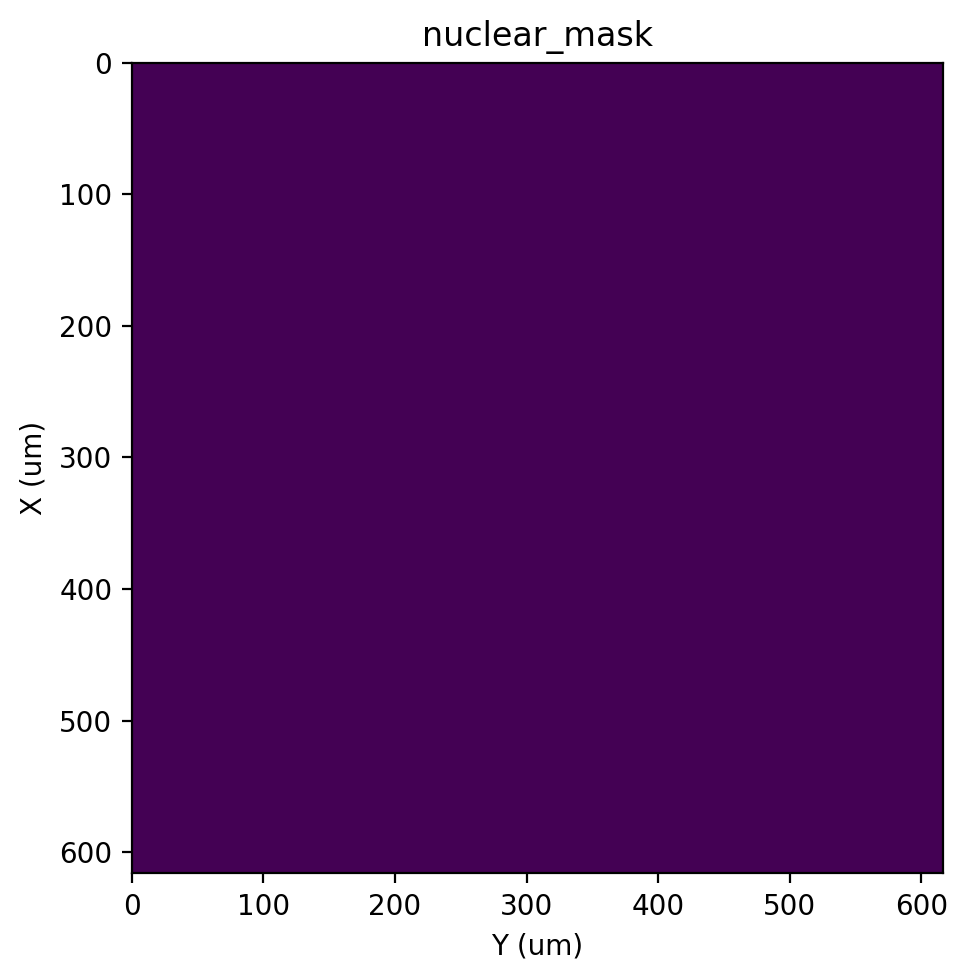

In [156]:
st.cs.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0, zero_inflated=True)
)

st.pl.imshow(adata, 'nuclear_mask')

|-----> <select> nuclear_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> nuclear_distances to layers in AnnData Object.
|-----> <insert> nuclear_markers to layers in AnnData Object.
|-----> <select> nuclear_distances layer in AnnData Object
|-----> <select> nuclear_mask layer in AnnData Object
|-----> <select> nuclear_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> nuclear_labels to layers in AnnData Object.
|-----> <select> nuclear_labels layer in AnnData Object


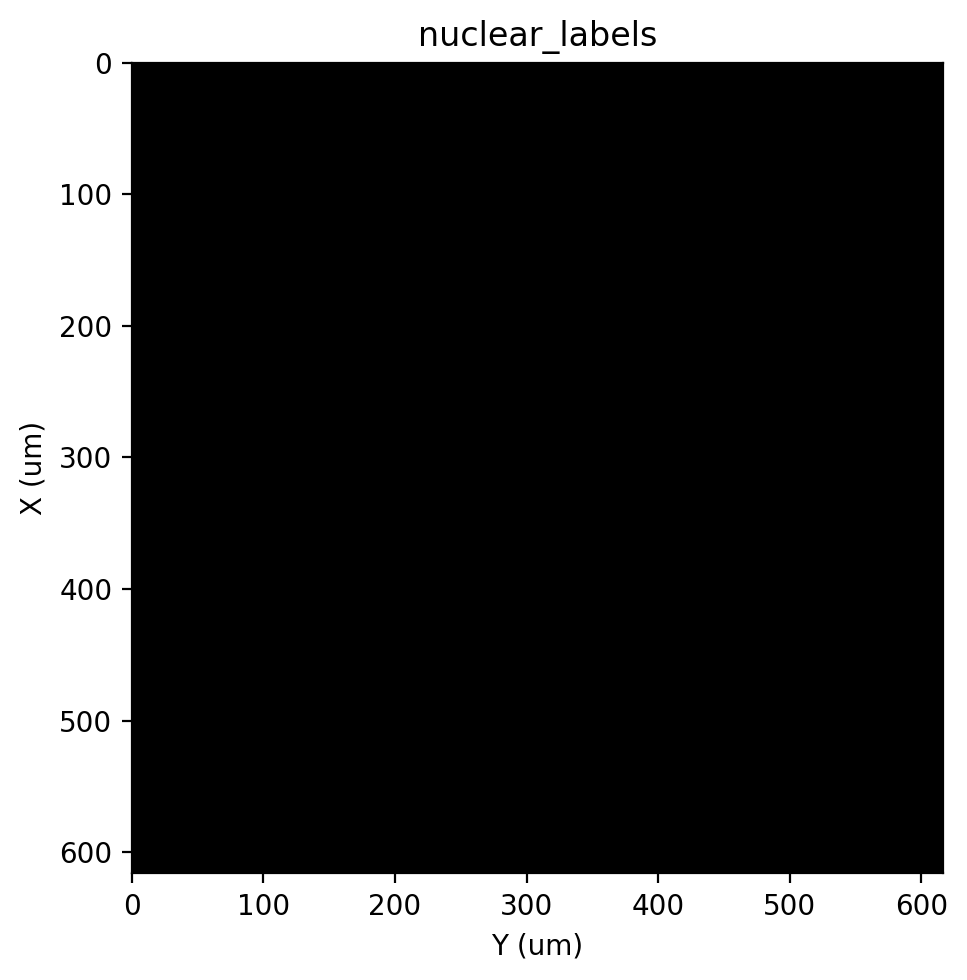

In [157]:
st.cs.find_peaks_from_mask(adata, 'nuclear', 7)
st.cs.watershed(
    adata, 'nuclear_distances', 1,
    mask_layer='nuclear_mask',
    markers_layer='nuclear_markers',
    out_layer='nuclear_labels'
)

st.pl.imshow(adata, 'nuclear_labels', labels=True)

In [104]:
adata.layers['unspliced'] = adata.X.copy()

|-----> <select> unspliced layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> unspliced_bins to layers in AnnData Object.
|-----> <select> unspliced_bins layer in AnnData Object


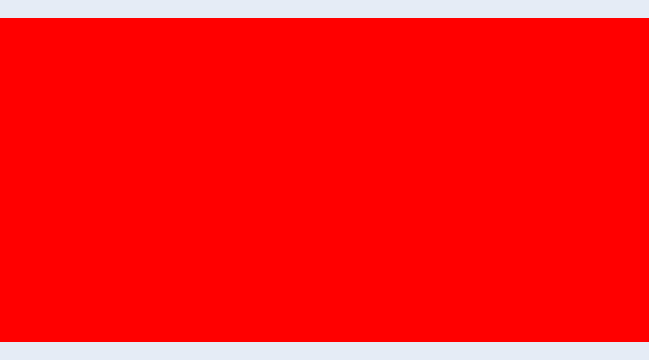

In [158]:
st.cs.segment_densities(adata, 'unspliced', 50, k=3, dk=3, distance_threshold=15, background=False)
st.pl.contours(adata, 'unspliced_bins', scale=0.15)

|-----> <select> unspliced layer in AnnData Object
|-----> <select> unspliced_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 9.0504e-01: 100%|██████████| 500/500 [00:16<00:00, 30.41it/s]


|-----> <insert> unspliced_scores to layers in AnnData Object.
|-----> Applying threshold 0.42443122122825516.
threshold: 0.42443122122825516
|-----> <insert> unspliced_mask to layers in AnnData Object.
|-----> <select> unspliced_mask layer in AnnData Object


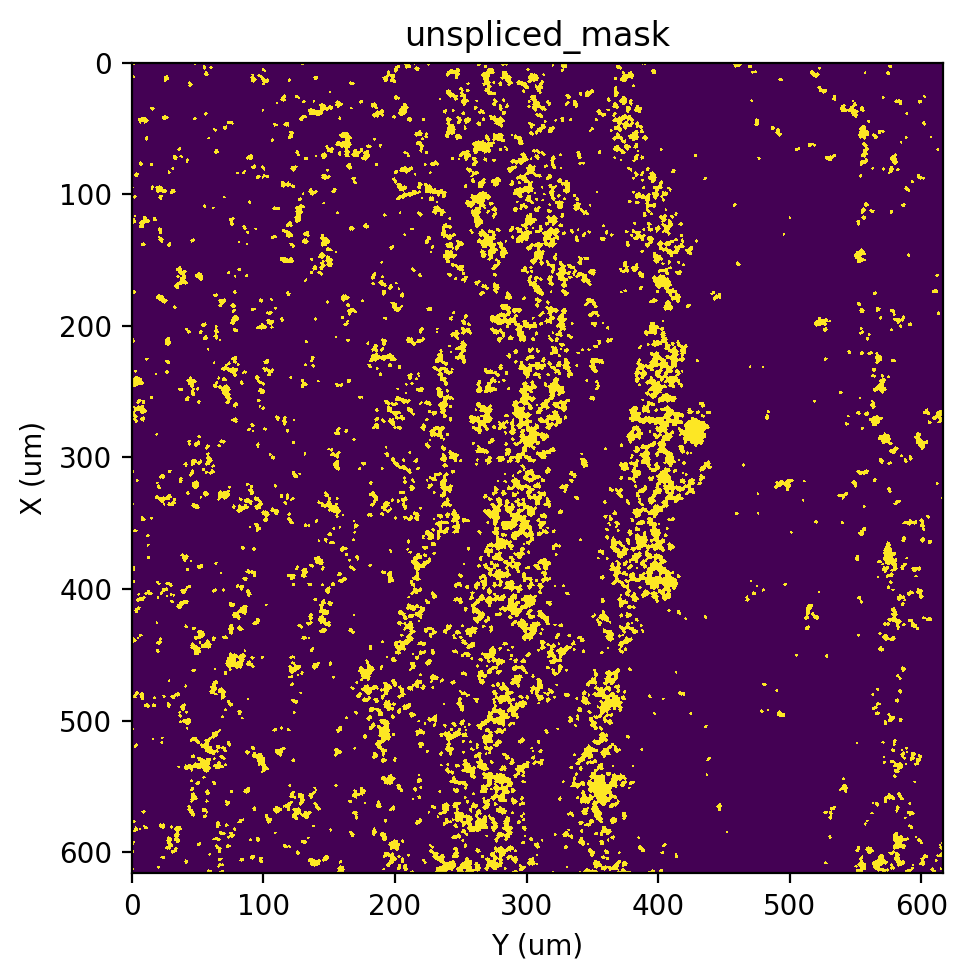

In [160]:
st.cs.score_and_mask_pixels(
    adata, 'unspliced', k=5, method='VI+BP',
    # vi_kwargs=dict(downsample=0.1, seed=0),
    # certain_layer='nuclear_labels'
)
st.pl.imshow(adata, 'unspliced_mask')

|-----> <select> unspliced_mask layer in AnnData Object


Eroding: 25it [00:00, 244.73it/s]
Expanding:   0%|          | 0/8 [00:00<?, ?it/s]2023-04-21 19:18:53.221835: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


2023-04-21 19:19:07.920721: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 19:19:08.170974: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 19:19:08.259526: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 19:19:08.278423: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly 

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|

Expanding:  12%|█▎        | 1/8 [00:44<05:12, 44.69s/it]2023-04-21 19:19:36.151808: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Expanding: 100%|██████████| 8/8 [00:59<00:00,  7.42s/it]

|-----> <insert> unspliced_labels to layers in AnnData Object.
|-----> <select> unspliced_labels layer in AnnData Object


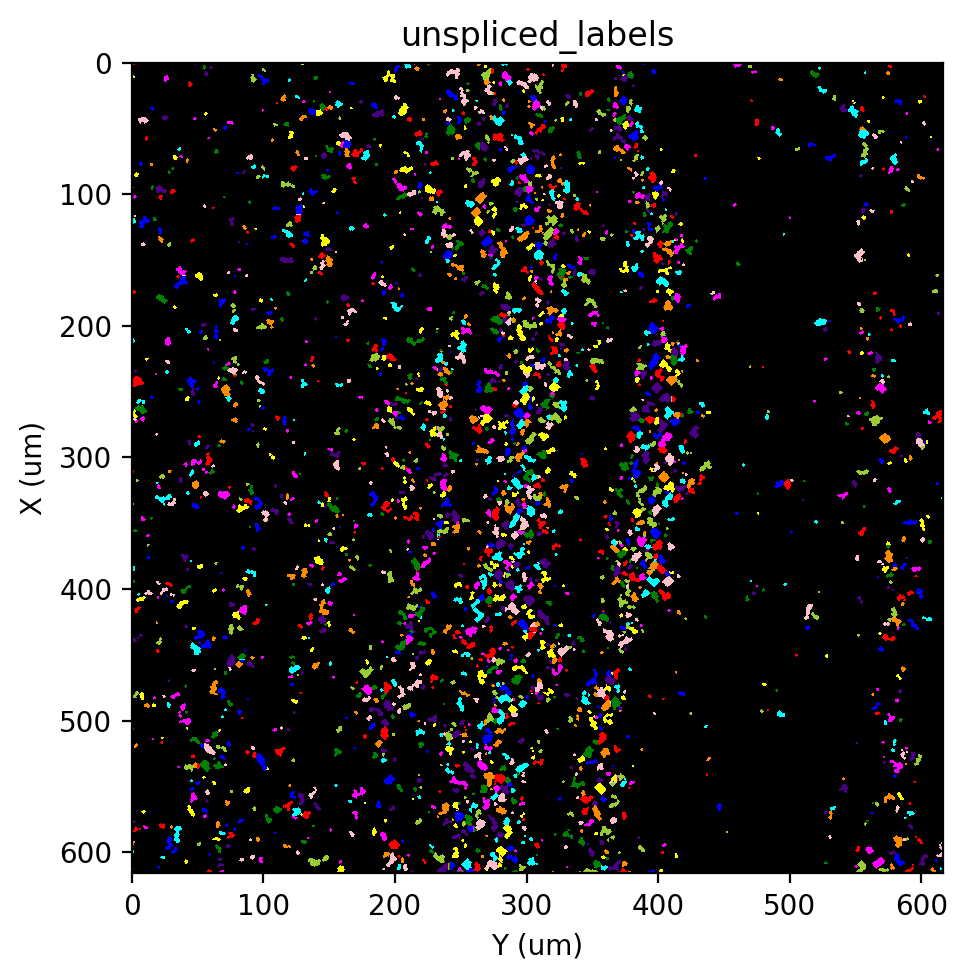

In [161]:
st.cs.label_connected_components(adata, 'unspliced')#, seed_layer='nuclear_labels')
st.pl.imshow(adata, 'unspliced_labels', labels=True)

|-----> <select> X layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> X_bins to layers in AnnData Object.
|-----> <select> X_bins layer in AnnData Object
|-----> <select> X_bins layer in AnnData Object


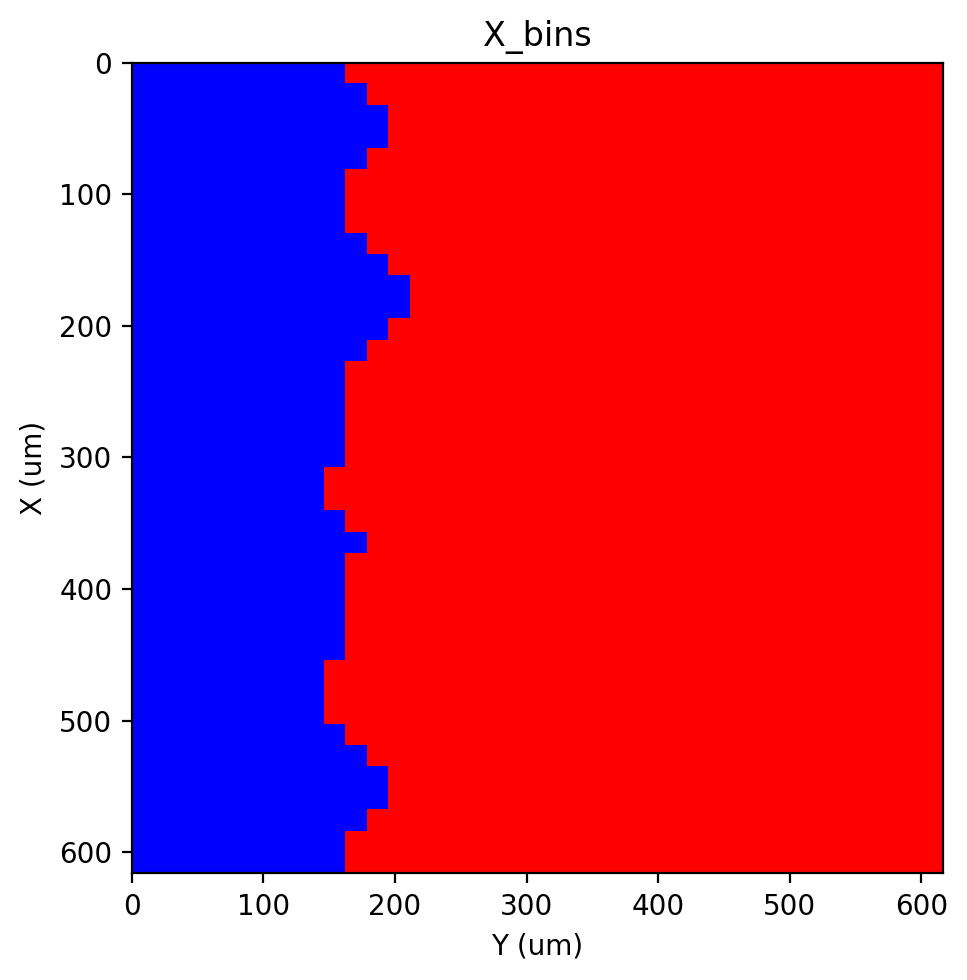

|-----> <select> X layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object
|-----> <select> X_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 3.9032e+00: 100%|██████████| 500/500 [00:08<00:00, 59.47it/s]


|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.5067918273756604.
threshold: 0.5067918273756604
|-----> <insert> X_mask to layers in AnnData Object.
|-----> <select> X_mask layer in AnnData Object


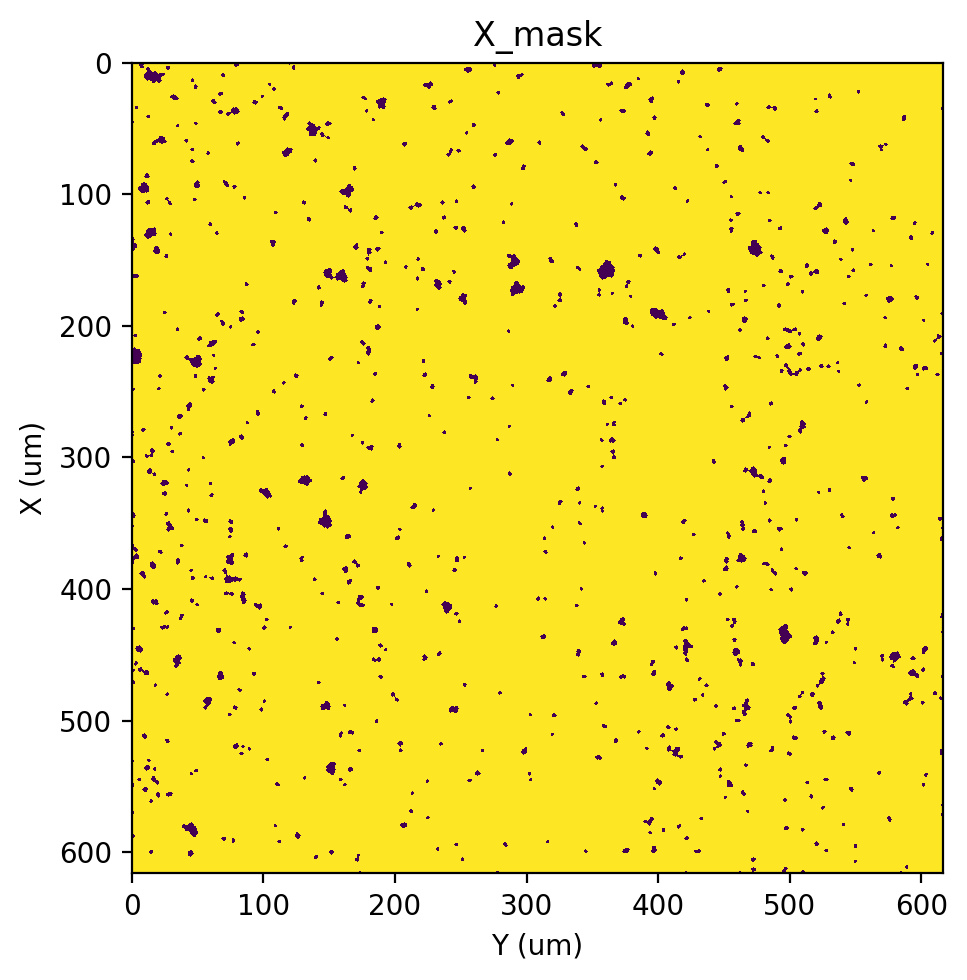

|-----> <select> X_mask layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object


Expanding:   0%|          | 0/8 [00:00<?, ?it/s]2023-04-22 17:44:14.824506: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


2023-04-22 17:44:31.750448: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 17:44:31.968904: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 17:44:32.200476: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 17:44:32.220213: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly 

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|

Expanding:  12%|█▎        | 1/8 [00:46<05:23, 46.18s/it]2023-04-22 17:45:00.141203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 17:45:00.229849: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Expanding: 100%|██████████| 8/8 [01:01<00:00,  7.66s/it]

|-----> <insert> X_labels to layers in AnnData Object.


In [186]:
st.cs.segment_densities(adata, 'X', 50, k=3, distance_threshold=3, dk=5, background=False)
st.pl.contours(adata, 'X_bins', scale=0.15)

st.pl.imshow(adata, 'X_bins', labels=True)

st.cs.score_and_mask_pixels(
    adata, 'X', k=7, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0),
    certain_layer='unspliced_labels'
)

st.pl.imshow(adata, 'X_mask')

st.cs.label_connected_components(adata, 'X', seed_layer='unspliced_labels')

# st.pl.imshow(adata, 'X_labels', labels=True, save_kwargs={'prefix': "expand1"})

In [191]:
adata

AnnData object with n_obs × n_vars = 1896 × 1896
    uns: '__type', 'pp', 'spatial'
    layers: 'nuclear', 'spliced', 'unspliced', 'nuclear_bins', 'nuclear_scores', 'nuclear_mask', 'nuclear_distances', 'nuclear_markers', 'nuclear_labels', 'unspliced_bins', 'unspliced_scores', 'unspliced_mask', 'unspliced_labels', 'X_bins', 'X_scores', 'X_mask', 'X_labels', 'X_labels_expanded', 'unspliced_distances', 'unspliced_markers', 'watershed_labels'

In [181]:
cell_count_df = pd.DataFrame(enumerate(np.bincount(np.unique(adata.layers['X_labels'], return_counts=True)[1][1:])))
cell_count_df[0] *= 0.105625
cell_count_df

,0,1
0,0.000000,0
1,0.105625,0
2,0.211250,0
3,0.316875,0
4,0.422500,0
...,...,...
494,52.178750,0
495,52.284375,1
496,52.390000,2
497,52.495625,1


In [ ]:
st.cs.expand_labels(
    adata, 'X_labels', distance=2, out_layer='X_labels_expanded'
)

st.pl.imshow(adata, 'X_labels_expanded', labels=True)

In [190]:
st.cs.find_peaks_from_mask(adata, 'unspliced', 7)
st.cs.watershed(adata, 'unspliced', 5, out_layer='watershed_labels')

|-----> <select> unspliced_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> unspliced_distances to layers in AnnData Object.
|-----> <insert> unspliced_markers to layers in AnnData Object.
|-----> <select> unspliced layer in AnnData Object
|-----> <select> unspliced_mask layer in AnnData Object
|-----> <select> unspliced_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.


|-----> <select> unspliced layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object


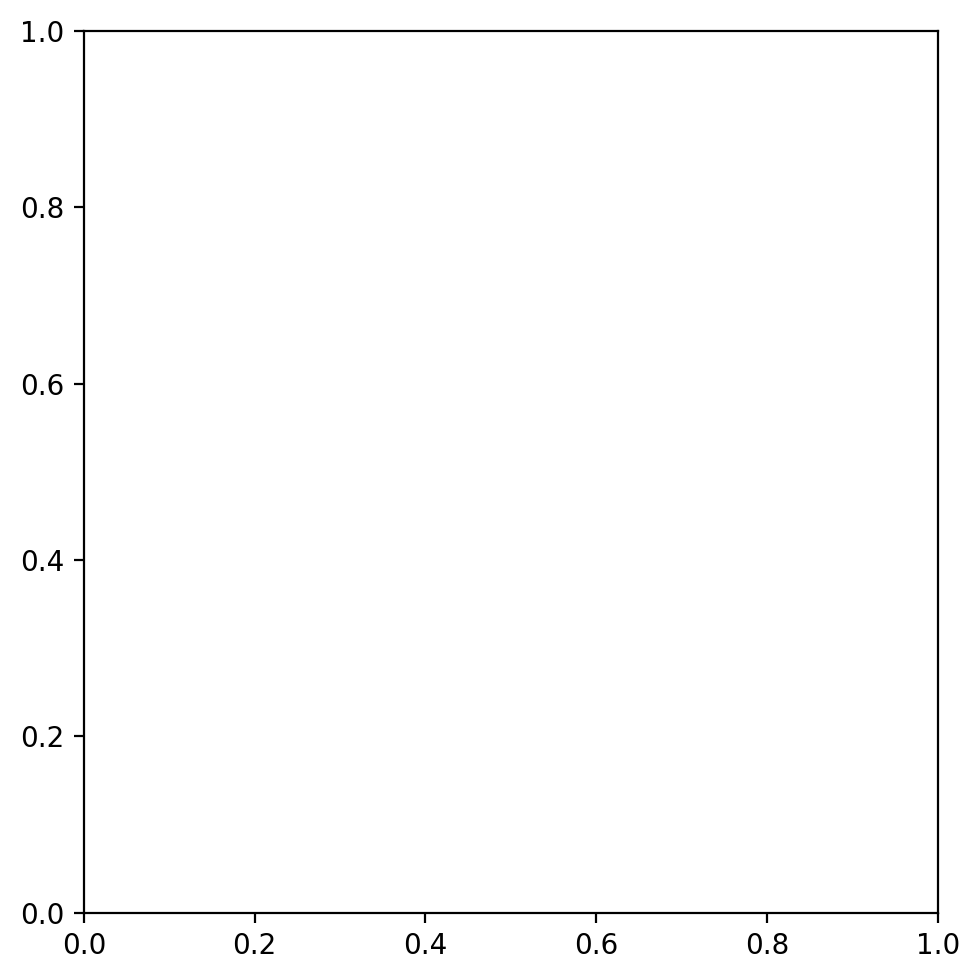

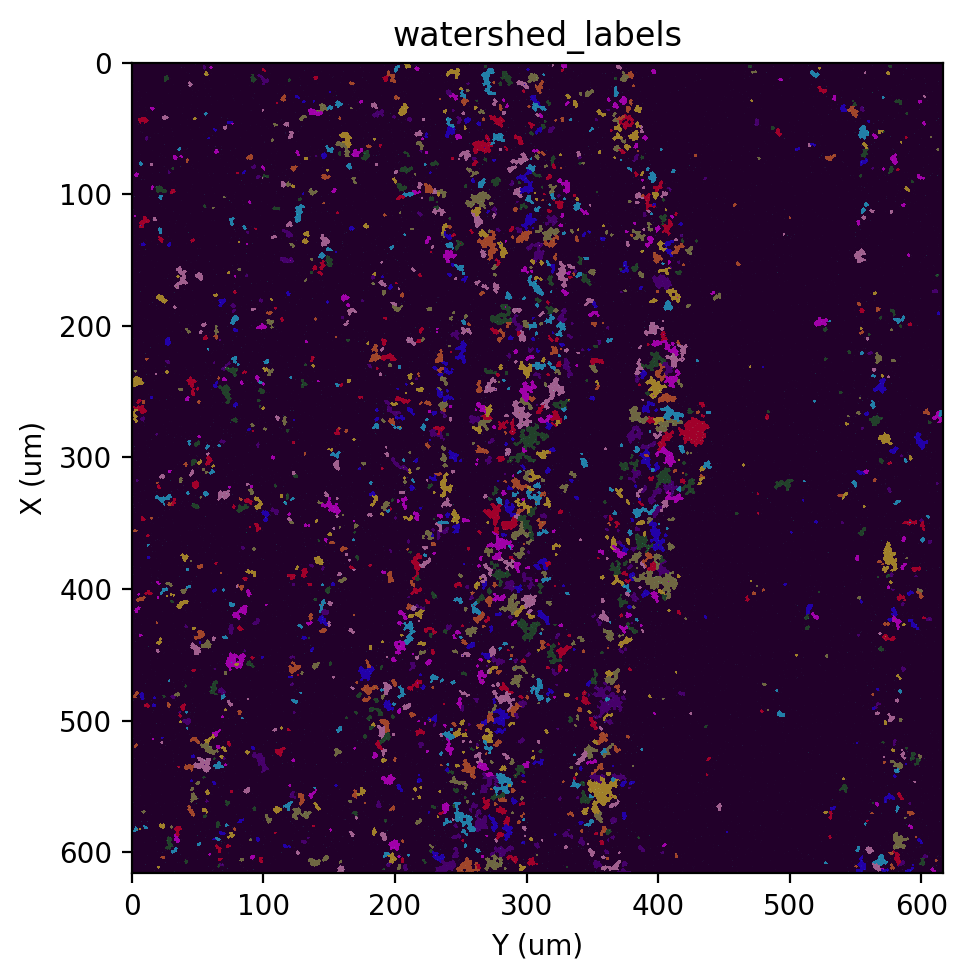

In [193]:
fig, ax = st.pl.imshow(adata, 'unspliced', save_show_or_return='return')
st.pl.imshow(adata, 'watershed_labels', labels=True, alpha=0.5, ax=ax)

|-----> <select> X_labels_expanded layer in AnnData Object
|-----> Set cell boundaries as value of 255
|-----> <insert> X_labels_expanded_boundary to layers in AnnData Object.
|-----> <select> unspliced layer in AnnData Object
|-----> <select> X_labels_expanded_boundary layer in AnnData Object


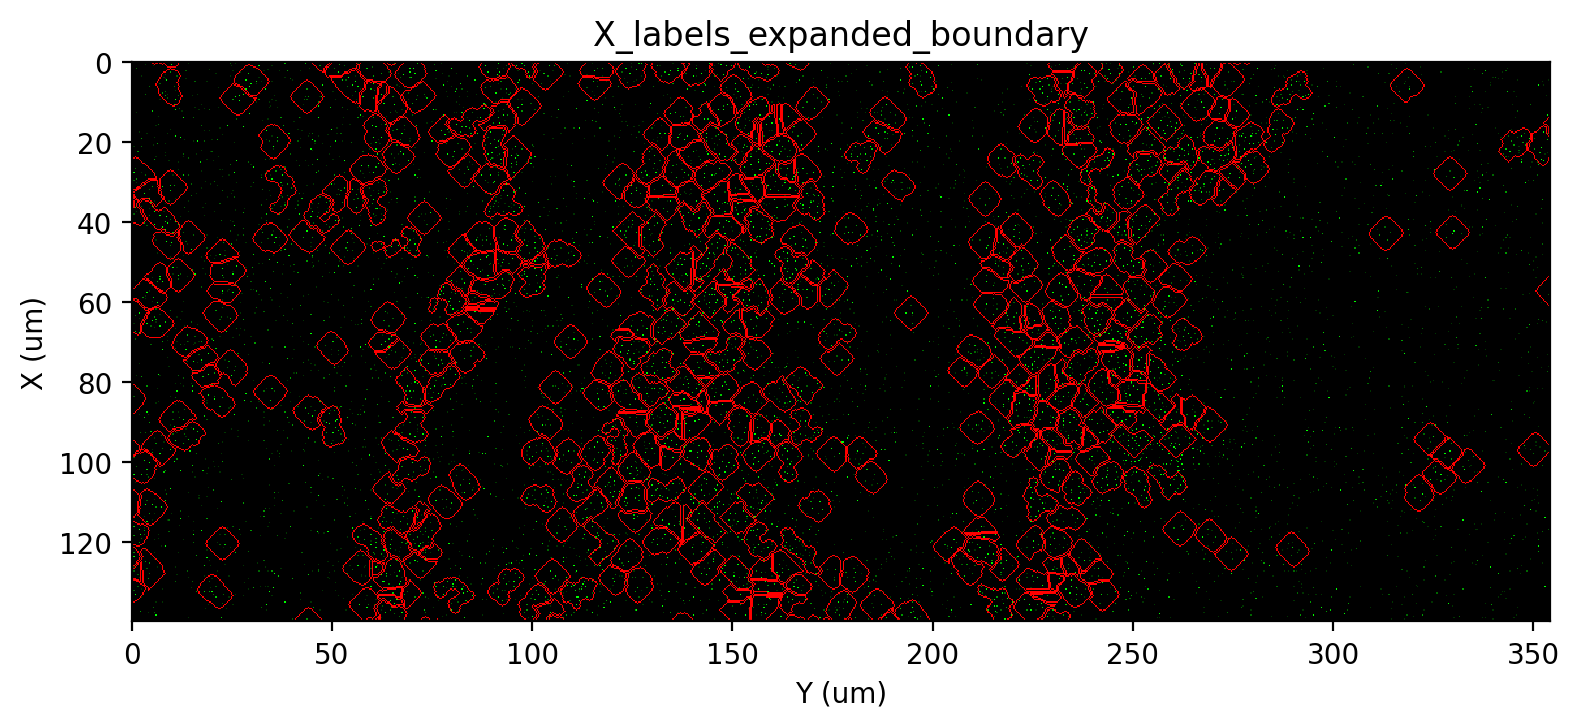

In [224]:
import matplotlib.colors as clr
st.cs.utils.get_cell_shape(adata, layer="X_labels_expanded", thickness=1)

fig, axes = plt.subplots(figsize=(8, 8), tight_layout=True)
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(1,'#00FF00')], N=256)
# st.pl.imshow(adata, 'unspliced', ax=axes, use_scale=False, save_show_or_return='return', cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#000000FF','#FFFFFFFF'], N=256))
st.pl.imshow(adata[923:1353, 449:1540], 'unspliced', ax=axes, use_scale=True, cmap=greenmap, vmax=5, save_show_or_return='return') #'save', save_kwargs={'prefix':'green1896'})
st.pl.imshow(adata[923:1353, 449:1540], 'X_labels_expanded_boundary', ax=axes, alpha=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=True, save_show_or_return='return')


# [736:805, 385:560] [923:1353, 449:1540] pixel coord
# [69, 175] [449, 1091] pixel length
# [] [] μm length
plt.savefig(r"6.pdf")
plt.show()
#cv2.imwrite("by1.baysor.cell_shape.tif", adata1.layers['baysor_boundary'])

In [ ]:
cell_adata = st.io.read_bgi(
    'slcFOV1896segcell.txt.gz',
    segmentation_adata=adata,
    labels_layer='X_labels_expanded',
)
cell_adata

|-----> <select> unspliced layer in AnnData Object


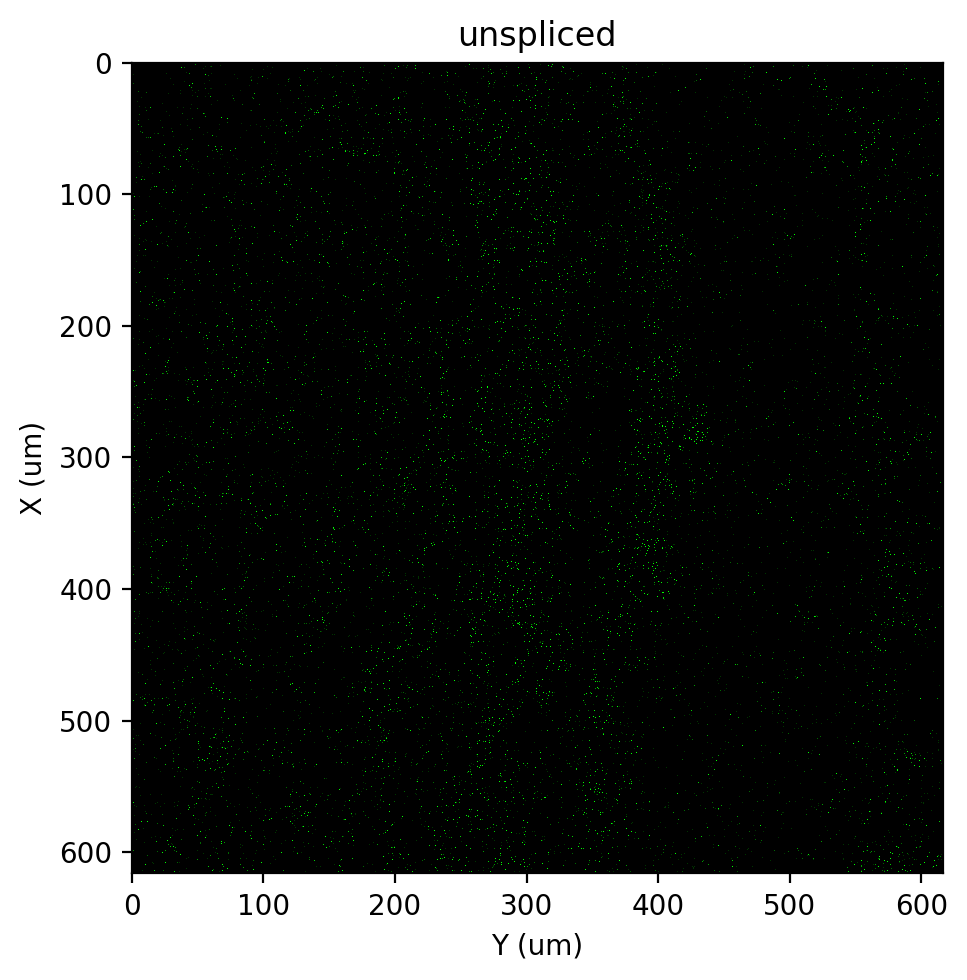

In [5]:
import matplotlib.colors as clr
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(1,'#00FF00')], N=256)
st.pl.imshow(adata, 'unspliced', cmap=greenmap, vmax=5, save_show_or_return='show', save_kwargs={'prefix':'green1896'})
plt.show()

In [8]:
adata

AnnData object with n_obs × n_vars = 1896 × 1896
    uns: '__type', 'pp', 'spatial'
    layers: 'nuclear', 'spliced', 'unspliced'

In [ ]:
import matplotlib.colors as clr
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(1,'#00FF00')], N=256)
st.pl.imshow(adata, 'X_labels_expanded', labels=True,vmax=5, save_show_or_return='show', save_kwargs={'prefix':'green1896'})
plt.show()

## New

In [2]:
adata = ad.read("/DATA/User/zhangzhewei/starro/slcFOV1896seg.h5ad")
adata

AnnData object with n_obs × n_vars = 1896 × 1896
    uns: '__type', 'pp', 'spatial'
    layers: 'X_bins', 'X_labels', 'X_labels_expanded', 'X_labels_expanded_boundary', 'X_mask', 'X_scores', 'nuclear', 'nuclear_bins', 'nuclear_distances', 'nuclear_labels', 'nuclear_markers', 'nuclear_mask', 'nuclear_scores', 'spliced', 'unspliced', 'unspliced_bins', 'unspliced_distances', 'unspliced_labels', 'unspliced_markers', 'unspliced_mask', 'unspliced_scores', 'watershed_labels'

|-----> <select> X_labels_expanded layer in AnnData Object


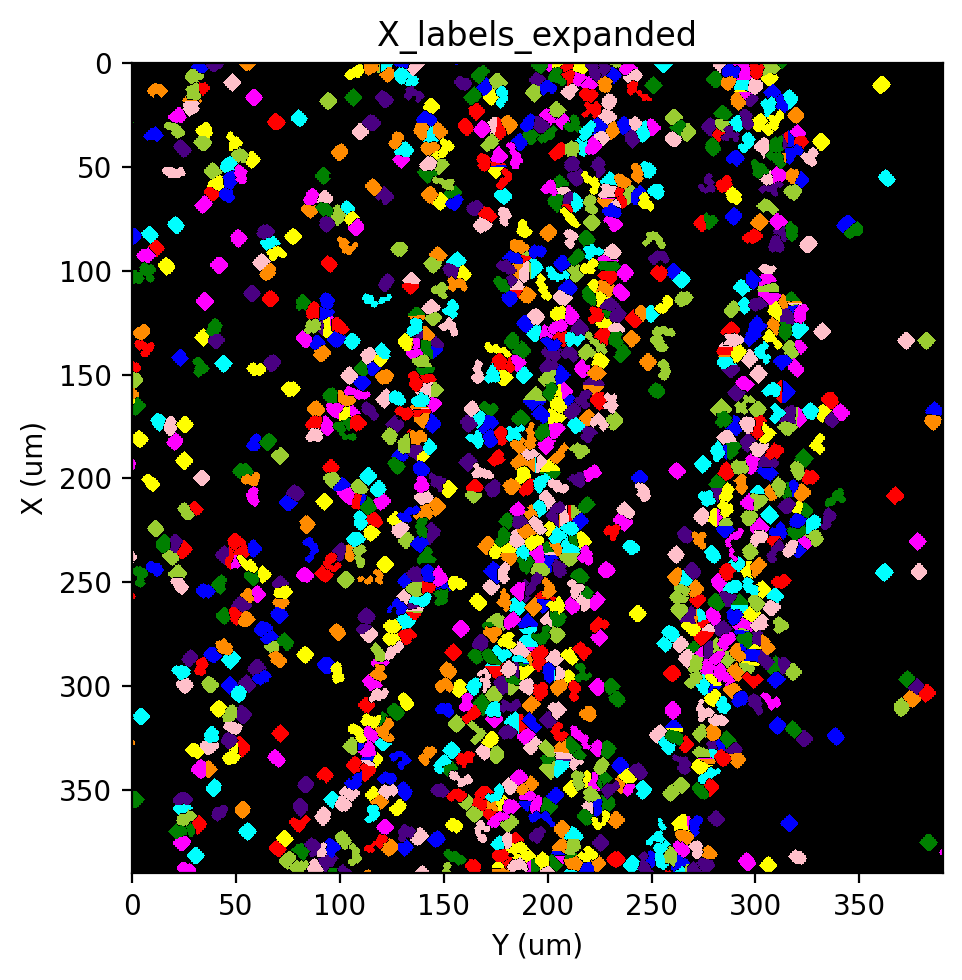

In [41]:
import matplotlib.colors as clr
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(1,'#00FF00')], N=256)
st.pl.imshow(adata[300:1500, 300:1500], 'X_labels_expanded', labels=True,vmax=5, save_show_or_return='show', save_kwargs={'prefix':'green1896'})
plt.show()

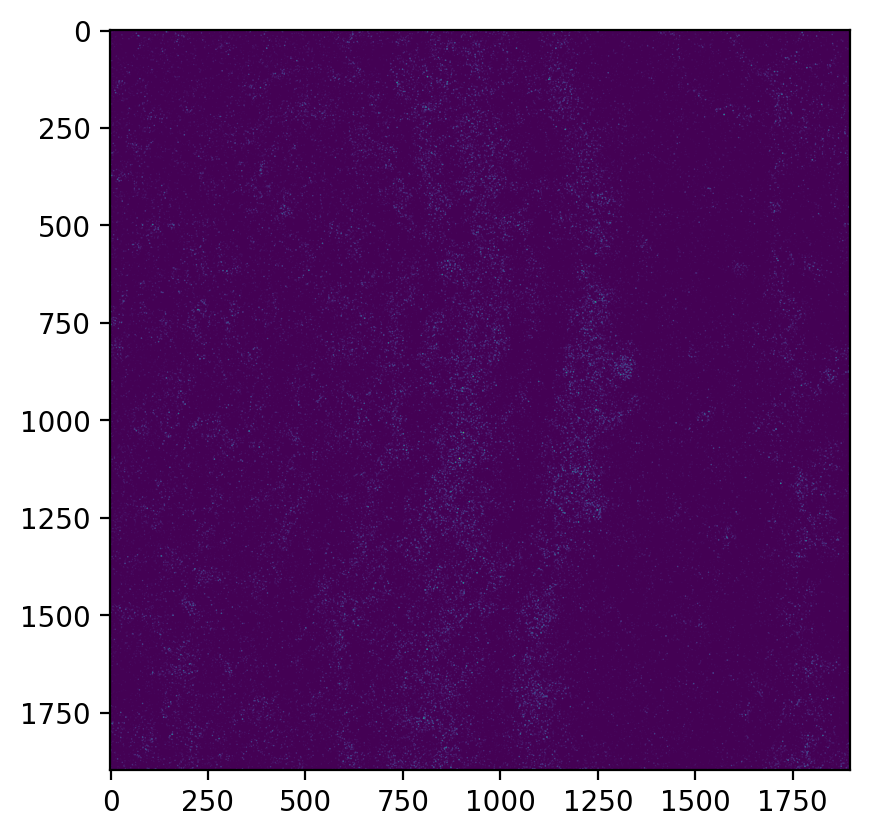

In [ ]:
aaaa = adata.layers['unspliced'].A.copy()
dilate_kernel = np.ones((3, 3), np.uint8)
aaaa = cv2.dilate(aaaa, dilate_kernel, iterations=1)
plt.imshow(aaaa)

adata.layers['unspliced_dilate'] = aaaa.copy()

In [84]:
adata.uns['spatial']['scale'] = 1

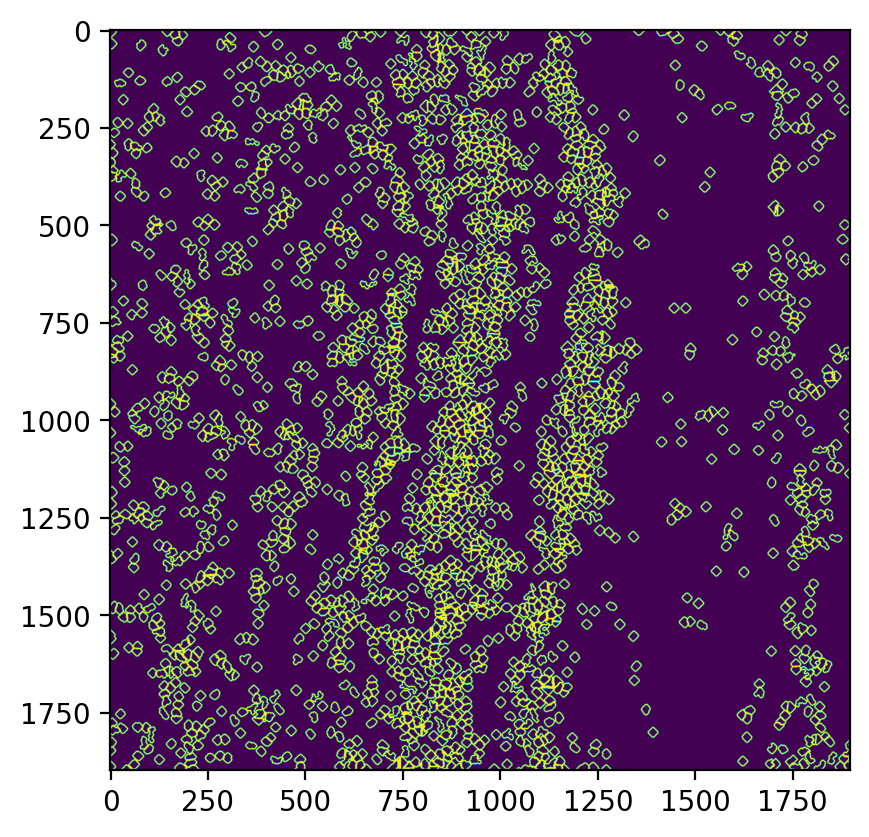

In [59]:
bdr = adata.layers['X_labels_expanded_boundary'].copy()
dilate_kernel = np.ones((3, 3), np.uint8)
bdr = cv2.dilate(bdr, dilate_kernel, iterations=1)
plt.imshow(bdr)

adata.layers['X_labels_expanded_boundary_dilate'] = bdr.copy()

|-----> <select> X_labels_expanded layer in AnnData Object
|-----> Set cell boundaries as value of 255
|-----> <insert> X_labels_expanded_boundary to layers in AnnData Object.
|-----> <select> unspliced_dilate layer in AnnData Object
|-----> <select> X_labels_expanded_boundary_dilate layer in AnnData Object


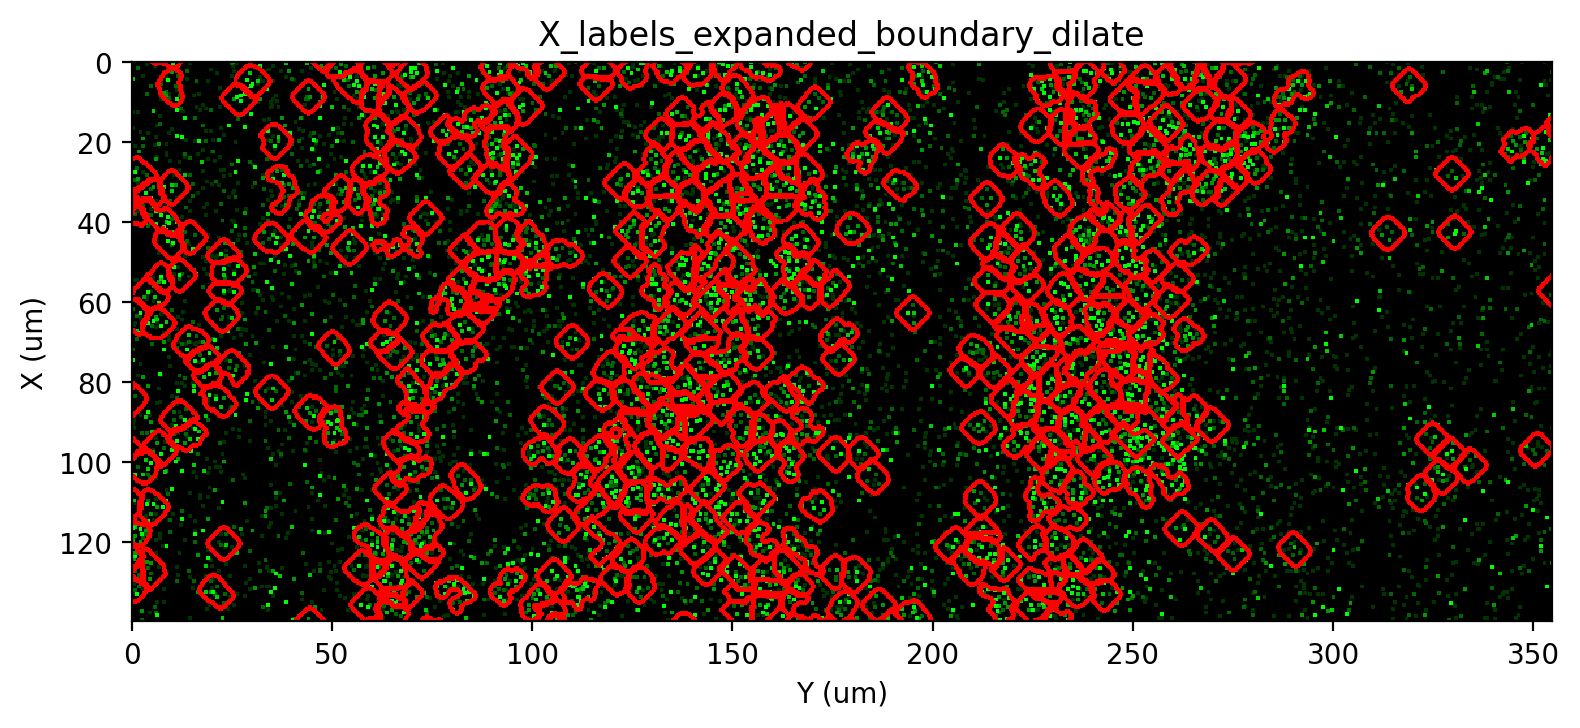

In [60]:
import matplotlib.colors as clr
st.cs.utils.get_cell_shape(adata, layer="X_labels_expanded", thickness=1)

fig, axes = plt.subplots(figsize=(8, 8), tight_layout=True)
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(1,'#00FF00')], N=256)
# st.pl.imshow(adata, 'unspliced', ax=axes, use_scale=False, save_show_or_return='return', cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#000000FF','#FFFFFFFF'], N=256))
st.pl.imshow(adata[923:1353, 449:1540], 'unspliced_dilate', ax=axes, use_scale=True, cmap=greenmap, vmax=5, save_show_or_return='return') #'save', save_kwargs={'prefix':'green1896'})
st.pl.imshow(adata[923:1353, 449:1540], 'X_labels_expanded_boundary_dilate', ax=axes, alpha=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=True, save_show_or_return='return')


# [736:805, 385:560] [923:1353, 449:1540] pixel coord
# [69, 175] [449, 1091] pixel length
# [] [] μm length
plt.savefig(r"6.pdf")
plt.show()
#cv2.imwrite("by1.baysor.cell_shape.tif", adata1.layers['baysor_boundary'])

|-----> <select> X_labels_expanded layer in AnnData Object
|-----> Set cell boundaries as value of 255
|-----> <insert> X_labels_expanded_boundary to layers in AnnData Object.
|-----> <select> unspliced layer in AnnData Object
|-----> <select> X_labels_expanded_boundary layer in AnnData Object


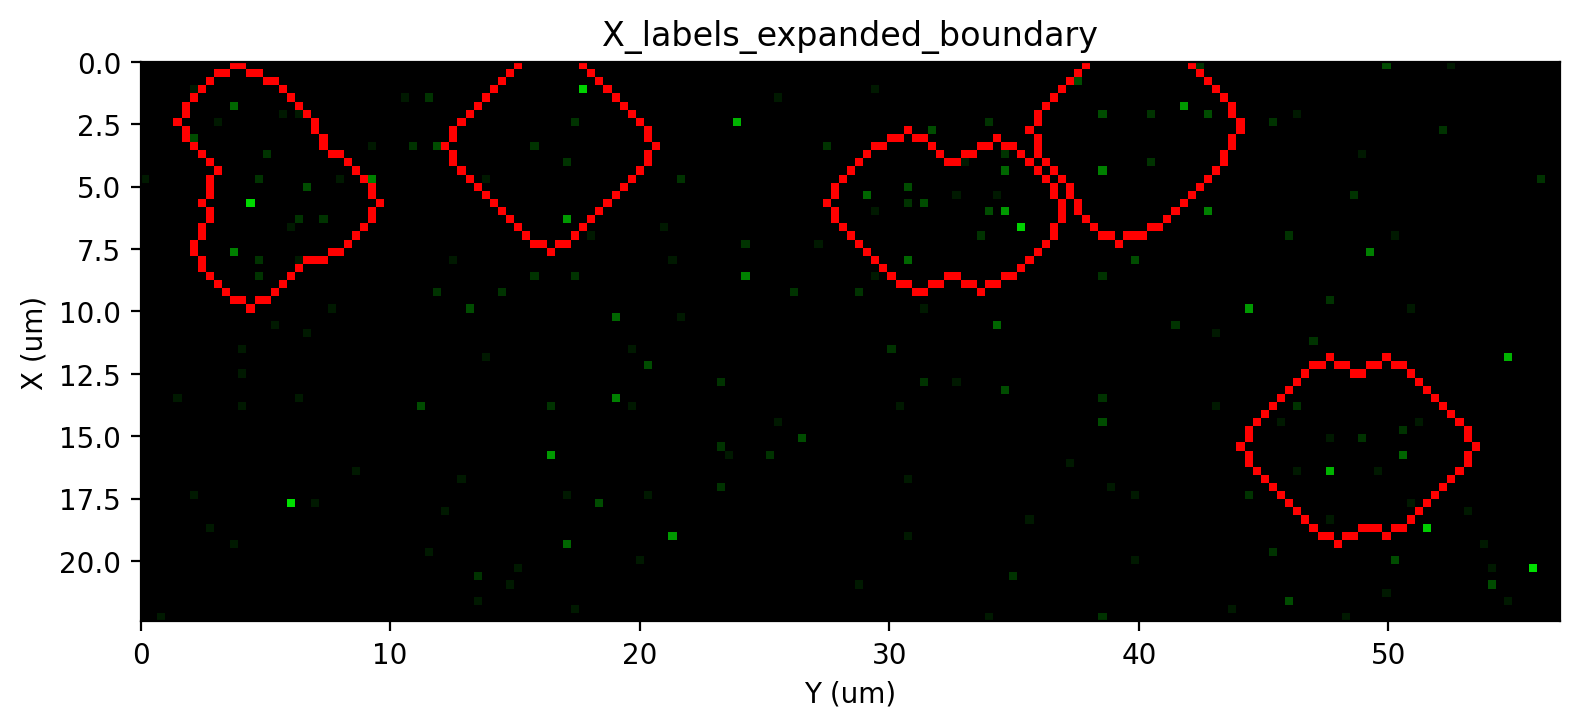

In [70]:
import matplotlib.colors as clr
st.cs.utils.get_cell_shape(adata, layer="X_labels_expanded", thickness=1)

fig, axes = plt.subplots(figsize=(8, 8), tight_layout=True)
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(0.5,'#00CC00'),(1,'#00FF00')], N=256)
# st.pl.imshow(adata, 'unspliced', ax=axes, use_scale=False, save_show_or_return='return', cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#000000FF','#FFFFFFFF'], N=256))
st.pl.imshow(adata[736:805, 385:560], 'unspliced', ax=axes, use_scale=True, cmap=greenmap, vmax=16, save_show_or_return='return') #'save', save_kwargs={'prefix':'green1896'})
st.pl.imshow(adata[736:805, 385:560], 'X_labels_expanded_boundary', ax=axes, alpha=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=True, save_show_or_return='return')


# [736:805, 385:560] [923:1353, 449:1540] pixel coord
# [69, 175] [449, 1091] pixel length
# [] [] μm length
plt.savefig(r"6.pdf")
plt.show()
#cv2.imwrite("by1.baysor.cell_shape.tif", adata1.layers['baysor_boundary'])

|-----> <select> X_labels_expanded layer in AnnData Object
|-----> Set cell boundaries as value of 255
|-----> <insert> X_labels_expanded_boundary to layers in AnnData Object.
|-----> <select> unspliced_dilate layer in AnnData Object
|-----> <select> X_labels_expanded_boundary layer in AnnData Object


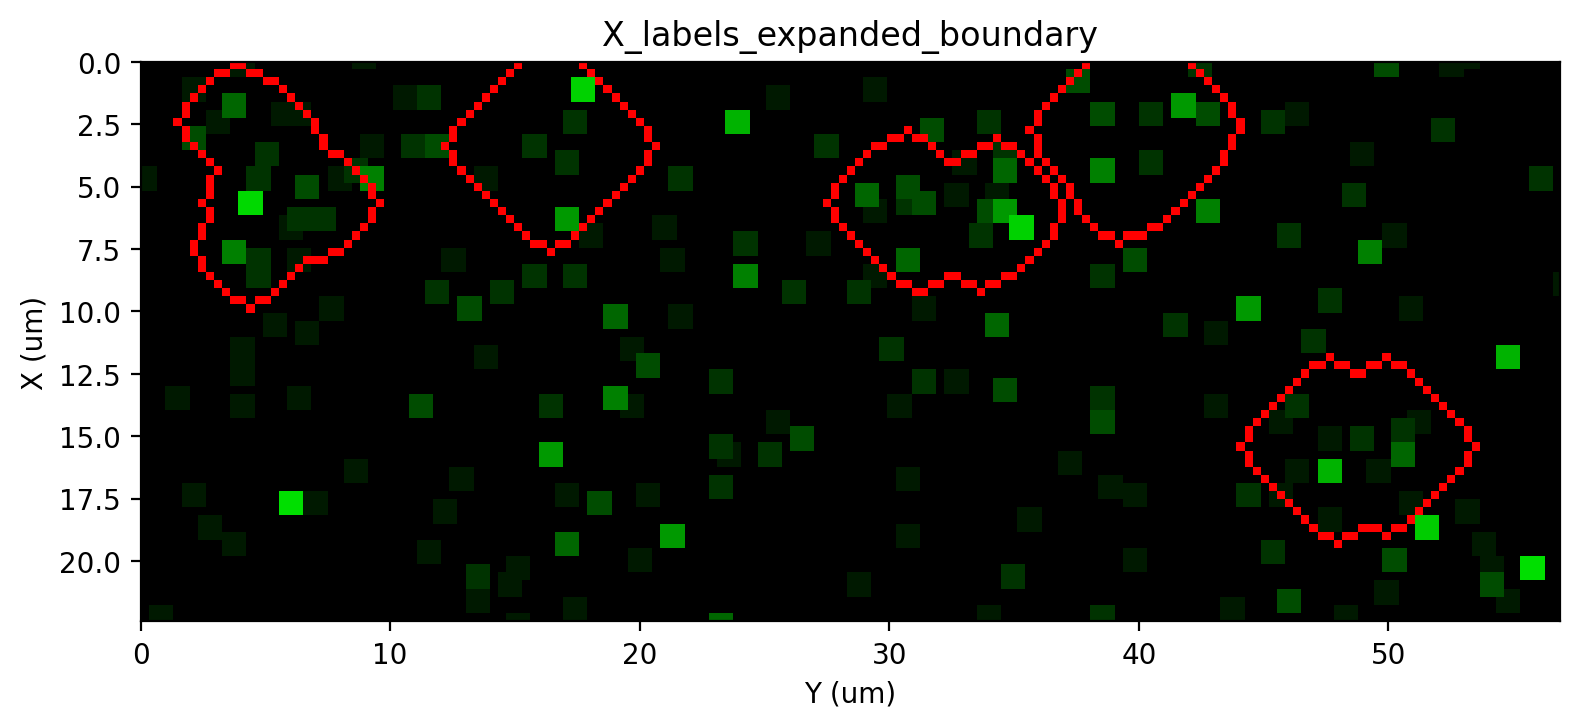

In [77]:
import matplotlib.colors as clr
st.cs.utils.get_cell_shape(adata, layer="X_labels_expanded", thickness=1)

fig, axes = plt.subplots(figsize=(8, 8), tight_layout=True)
greenmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0,'#000000'),(0.5,'#00CC00'),(1,'#00FF00')], N=256)
# st.pl.imshow(adata, 'unspliced', ax=axes, use_scale=False, save_show_or_return='return', cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#000000FF','#FFFFFFFF'], N=256))
st.pl.imshow(adata[736:805, 385:560], 'unspliced_dilate', ax=axes, use_scale=True, cmap=greenmap, vmax=16, save_show_or_return='return') #'save', save_kwargs={'prefix':'green1896'})
st.pl.imshow(adata[736:805, 385:560], 'X_labels_expanded_boundary', ax=axes, alpha=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=True, save_show_or_return='return')


# [736:805, 385:560] [923:1353, 449:1540] pixel coord
# [69, 175] [449, 1091] pixel length
# [] [] μm length
plt.savefig(r"6.pdf")
plt.show()
#cv2.imwrite("by1.baysor.cell_shape.tif", adata1.layers['baysor_boundary'])